In [147]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

<IPython.core.display.Javascript object>

In [9]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib import rcParams
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 500
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
import corner
from orvara import corner_modified
from orvara.format_fits import pull_chain_params, burnin_chain
import sys

In [11]:
# This might not be very helpful, because most plots below need to be adjusted individually
def adjust_font():
    
    plt.rcParams.update(plt.rcParamsDefault)
    font = {
#         'font.size': 15,   # this affects the axis label, text, and title
        'axes.labelsize': 14, 
        'axes.titlesize': 14, 
        'xtick.labelsize': 13, 
        'ytick.labelsize': 13,
        'legend.fontsize': 11, 
        'savefig.dpi': 500
#         'axes.labelpad': 20
#         'figure.titlesize': 15  # does not take effect
    }
    plt.rcParams.update(**font)
    
    return 

def ax_fmt(ax, fname='', legend=True, legend_loc='auto', square=True, savefig=True):
    """
    set legend_loc = 'auto' to ax.legend()
    """
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='both', which='both', direction="in", left=True, right=True, bottom=True, top=True)
    if square == True:
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
        
    handles, labels = ax.get_legend_handles_labels()
    if labels != []:     # check there is(are) label(s)
        if legend == True:
            if legend_loc == 'auto':
                ax.legend()
            else:
                ax.legend(loc=legend_loc, bbox_to_anchor=(1.0, 0.5))
    fig.tight_layout()
    if savefig == True:
        fig.savefig(fname, bbox_inches='tight')
    
    return

In [12]:
# set True if don't want to run the whole notebookd
break_MCMC = False
break_MESA = False
break_Mercury = False
turnoff_cornor = False

# MCMC

In [13]:
path = '/Users/yunlin/Dropbox (GaTech)/physics/research/Gl86/MCMC_chains_from_orvara/'

# absAst_err *= 2. no companion absAst (companion_ID = -1)
# Gl86_relAST00_plus_Tim2019_inflate_plus_manual_inflate_0.010_0.05.txt
file = 'Gl86B_chain047.fits'
# plx_ML = 0.09292300385993202
# pmra_ML = 2.1416346481968023
# pmdec_ML = 0.665559336186888
# chisq_PA = 11.345390741454578
# chisq_sep = 11.76045690643476
# chisq_H = 1.8872448308089407
# chisq_HG = 0.028565534394147732
# chisq_G = 0.717029693665133

In [14]:
source = file.split('_')[0][:4]
burnin = 2500

# how the data were read in orbit_plot.py's load_mcmc_data function
header0 = fits.open(path + file)[0].header
header1 = fits.open(path + file)[1].header
chain = fits.open(path + file)[1].data
chain_after_burnin = burnin_chain(chain.columns, burnin, reshape=True)   # was named as chain in orbit_plot.py

nsteps = np.shape(chain['mpri'])[1]*50

par_label = ['plx_ML', 'pmra_ML', 'pmdec_ML', 'chisq_PA', 'chisq_sep', 'chisq_H', 'chisq_HG', 'chisq_G']
lnp = chain_after_burnin['lnp']   # be careful lnp = chain_after_burnin['lnp'] or lnp = chain['lnp']
idx = np.where(lnp == np.amax(lnp))[0][0]
for par in par_label:
    print(par + ' = {}'.format(chain_after_burnin[par][idx]))

plx_ML = 0.09292300385993202
pmra_ML = 2.1416346481968023
pmdec_ML = 0.665559336186888
chisq_PA = 11.345390741454578
chisq_sep = 11.76045690643476
chisq_H = 1.8872448308089407
chisq_HG = 0.028565534394147732
chisq_G = 0.717029693665133


## Corner Plots

In [15]:
# modify the corner plot code from t-brandt github
def plot_corner(chain, iplanet, msec_unit='solar', fname=None, kwargs_corner={}):
    
    plt.rcParams.update(plt.rcParamsDefault)
    font = {
        'axes.labelsize': 20,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'savefig.dpi': 200
    }
    plt.rcParams.update(**font)

    npl = '%d' % (iplanet)
    mpri = chain['mpri']
    sau = chain['sau' + npl]
    ecc = chain['esino' + npl]**2 + chain['ecoso' + npl]**2
    inc = chain['inc' + npl]
#     omega = chain['omega' + npl]
    asc = chain['asc' + npl]
    lam = chain['lam' + npl]
    
    if msec_unit == 'solar':
        msec = chain['msec' + npl]   # in M_{\odot}
        msec_label = r'$\mathrm{M_{comp}\, (M_{\odot})}$'
    else:
        msec = chain['msec' + npl]*1989/1.898   # in M{\Jup}
        msec_label = r'$\mathrm{M_{comp}\, (M_{Jup})}$'

    chain = np.vstack([mpri, msec, sau, ecc, inc*180/np.pi, asc*180/np.pi, lam*180/np.pi]).T
    labels=[r'$\mathrm{M_{host}\, (M_{\odot})}$', msec_label, 'a (AU)', r'e', 
            r'$\mathrm{i\, (^{\circ})}$', r'$\mathrm{\Omega\, (^{\circ})}$', 
            r'lam $\mathrm{\, (^{\circ})}$']
    
    # in corner_modified, the error is modified to keep 2 significant figures
    fig = corner_modified.corner(
        chain, labels=labels, quantiles=[0.16, 0.5, 0.84], 
        range=[0.999 for l in labels], verbose=False, show_titles=True, 
        title_kwargs={"fontsize":15}, hist_kwargs={"lw":1.}, 
        label_kwargs={"fontsize":20}, 
        xlabcord=(0.5,-0.45), ylabcord=(-0.45,0.5),  
        **kwargs_corner
    )

    fig.savefig('plots/' + fname + '.pdf')

# pass msini to the argument
def plot_corner_less(chain, msini, iplanet, msec_unit='solar', fname=None, kwargs_corner={}):
    
    plt.rcParams.update(plt.rcParamsDefault)
    font = {
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'savefig.dpi': 200
    }
    plt.rcParams.update(**font)

    npl = '%d' % (iplanet)
    mpri = chain['mpri']
    sau = chain['sau' + npl]
    ecc = chain['esino' + npl]**2 + chain['ecoso' + npl]**2
    lam = chain['lam' + npl]
    msini = msini[:, burnin:].flatten()
    
    if msec_unit == 'solar':
        msec = chain['msec' + npl]   # in M_{\odot}
        msec_label = r'$\mathrm{M_{comp}\, (M_{\odot})}$'
    else:
        msec = chain['msec' + npl]*1989/1.898   # in M{\Jup}
        msec_label = r'$\mathrm{M_{comp}\, (M_{Jup})}$'

    chain = np.vstack([mpri, msini, sau, ecc, lam*180/np.pi]).T
    labels=[r'$\mathrm{M_{host}\, (M_{\odot})}$', r'$\mathrm{m\,\sin{i}\, (M_{Jup})}$',
            'a (AU)', r'e', 
            r'lam $\mathrm{\, (^{\circ})}$']
    
    # in corner_modified, the error is modified to keep 2 significant figures
    fig = corner_modified.corner(
        chain, labels=labels, quantiles=[0.16, 0.5, 0.84], 
        range=[0.999 for l in labels], verbose=False, show_titles=True, 
        title_kwargs={"fontsize":12}, hist_kwargs={"lw":1.}, 
        label_kwargs={"fontsize":15}, xlabcord=(0.5,-0.45), ylabcord=(-0.45,0.5),
        **kwargs_corner
    )
    
    fig.savefig('plots/' + fname + '.pdf')

### Companion1

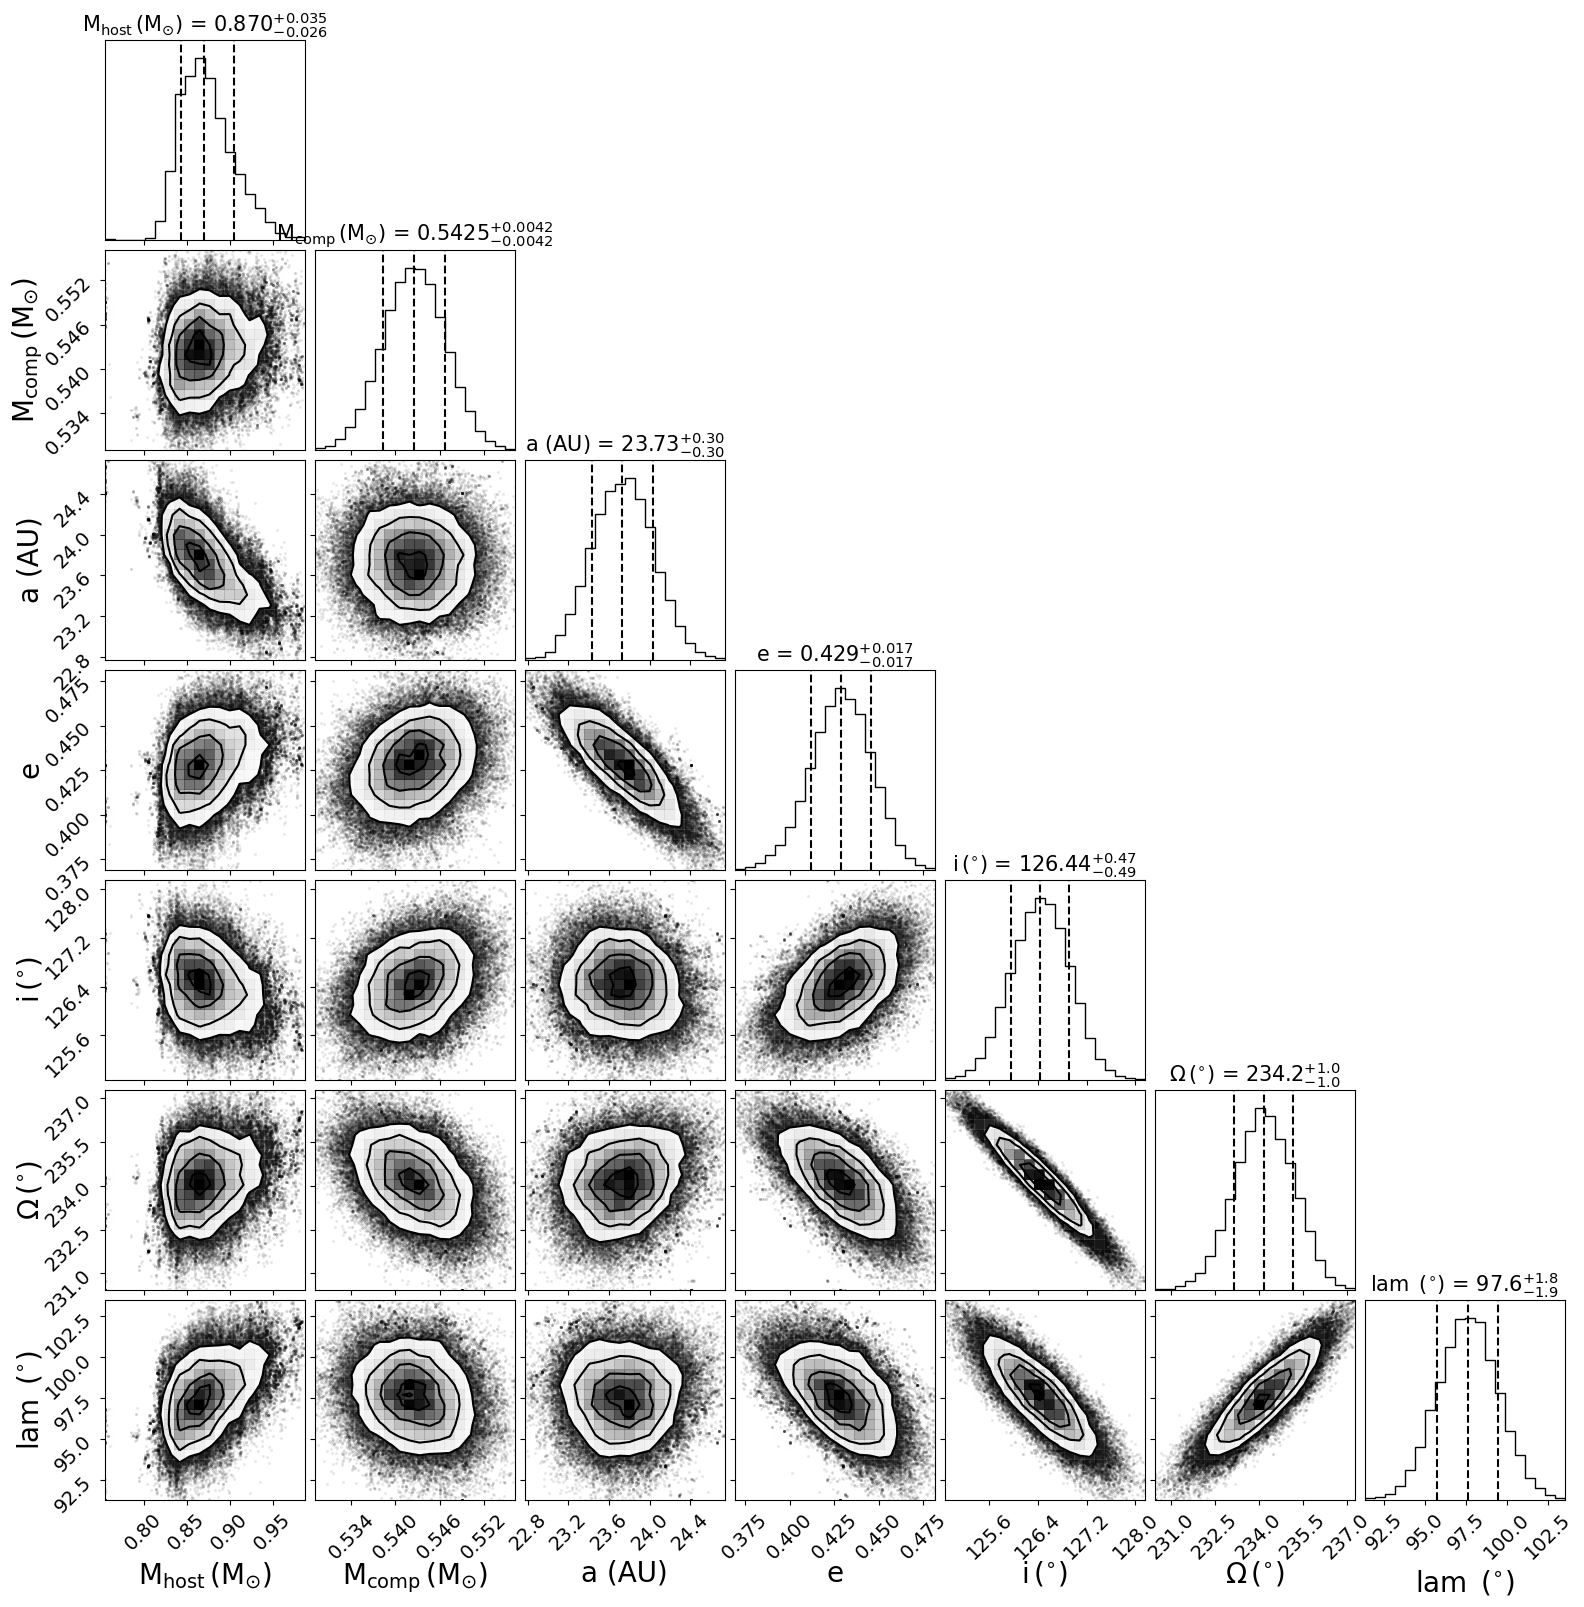

In [17]:
if turnoff_cornor == True:
    pass
else:
    kwargs_others = {'iplanet':0, 'msec_unit':'solar', 'fname':'current_orbit_Gl86B/corner_B'}
    plot_corner(chain_after_burnin, **kwargs_others)

### Companion2

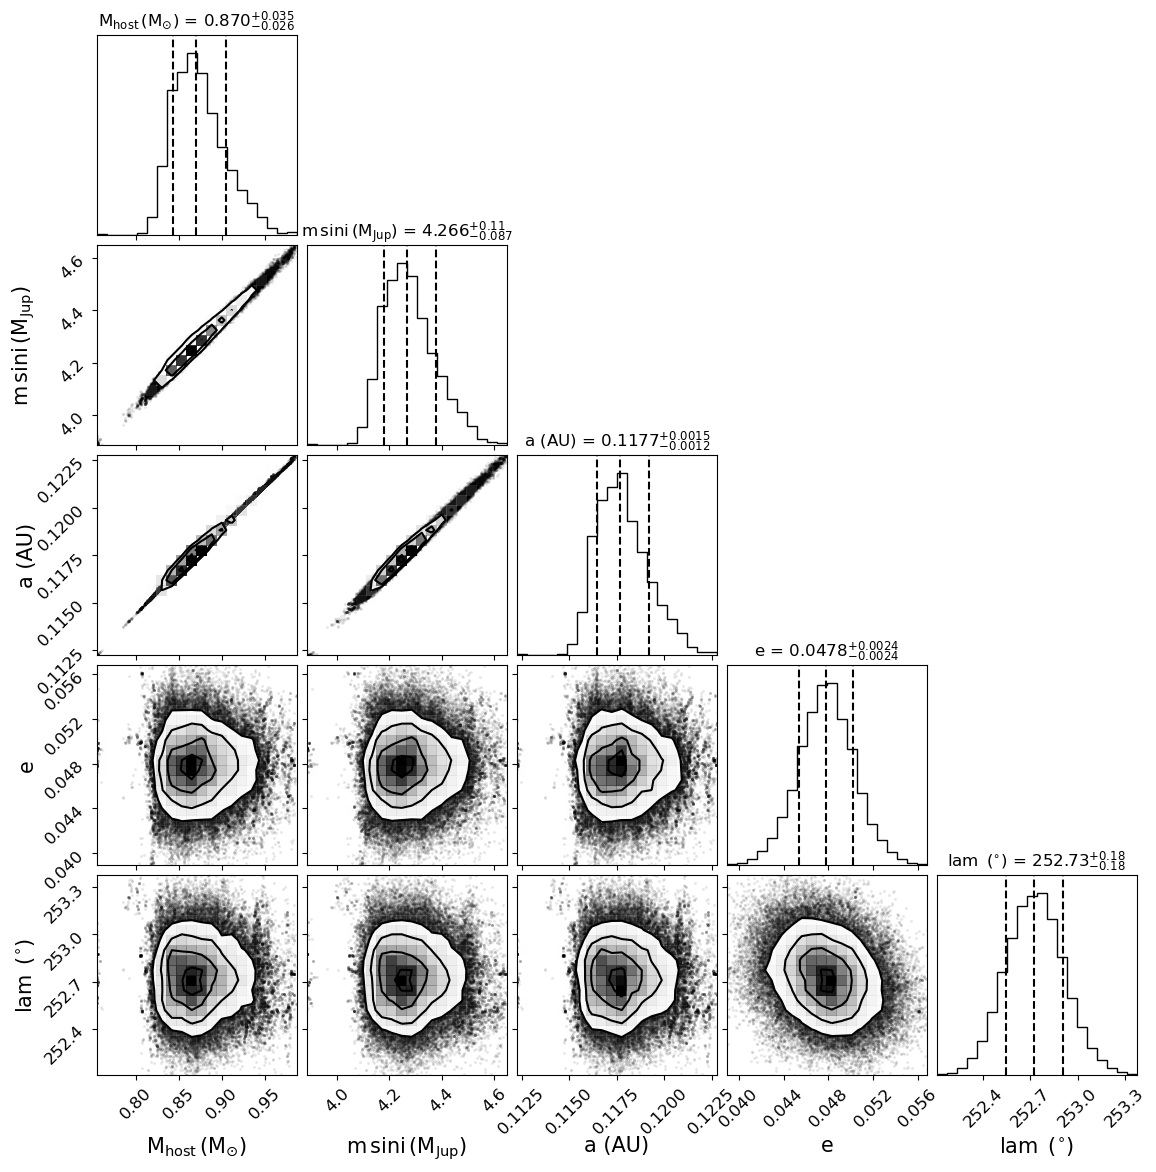

In [18]:
if turnoff_cornor == True:
    pass
else:
    msini = np.sin(chain['inc1'])*chain['msec1']*1048
    msini_burnin = msini[:, burnin:]*1048    # 1048 is Msun/Mjup
    kwargs_others = {'iplanet':1, 'msec_unit':'jupiter', 'fname':'current_orbit_Gl86Ab/corner_Ab'}
    plot_corner_less(chain_after_burnin, msini, **kwargs_others)

In [19]:
# save the results of variables for later use
# However, these results are the mean of the sample, while the corner plot uses the 16-50-84 percentile
# So, I will adopt the median instead
par = chain['mpri']
M1 = MA = np.mean(par[:, burnin:])
par = chain['msec0']
M2 = MB = np.mean(par[:, burnin:])
par = chain['msec1']
Mb = np.mean(par[:, burnin:])   # in terms of Msun. cannot call Mb m because there are (m, l)'s below
par = chain['sau0']
a1 = aB = np.mean(par[:, burnin:])
par = chain['sau1']
a2 = ab = np.mean(par[:, burnin:])
par = chain['esino0']**2 + chain['ecoso0']**2
e1 = e_Gl86 = np.mean(par[:, burnin:])       # in Mercury analysis I called it e1. In disk mass I called it e_Gl86
par = chain['esino1']**2 + chain['ecoso1']**2
e2 = np.mean(par[:, burnin:])

print(M1, M2, Mb, a1, a2, e1, e2)

# manually change M1 and Mb to make them consistent with the 50th percentile value
# other parameter's mean are all consistent with the median
M1 = 0.870
print('mass of the planet in terms of Jupiter mass is {:.6g}'.format(Mb*1048))

M_tot = M1 + M2 + Mb
# M2i(MBi) will be defined in the MESA section

0.8736095672439866 0.5424875614378722 0.004666388504909734 23.73262174467242 0.11781950557148542 0.42861485672471167 0.047796623808232436
mass of the planet in terms of Jupiter mass is 4.89038


In [20]:
if break_MCMC == True:
    sys.exit()

In [21]:
print(e_Gl86)

0.42861485672471167


# MESA

In [22]:
import mesa_reader as mr
from scipy.interpolate import interp1d

In [26]:
# figure font for MESA section
def MESA_font():
    
    plt.rcParams.update(plt.rcParamsDefault)
    font = {
#         'font.size': 15,   # this affects the axis label, text, and title
        'axes.labelsize': 14, 
        'axes.titlesize': 14, 
        'xtick.labelsize': 13, 
        'ytick.labelsize': 13,
        'legend.fontsize': 11, 
        'savefig.dpi': 500
    }
    plt.rcParams.update(**font)
    
    return 

MESA_font()

path = 'mesa_works/1M_pre_ms_to_wd_1/'
# path = 'mesa_works/1.4M_pre_ms_to_wd/'

suffix = '_139'
# M_Gl86B initial mass
M2i = MBi = 1.39

# load and plot data
h1 = mr.MesaData(path + 'LOGS_start' + suffix + '/history.data')
h2 = mr.MesaData(path + 'LOGS_to_end_agb' + suffix + '/history.data')
h3 = mr.MesaData(path + 'LOGS_to_wd' + suffix + '/history.data')

# load entire LOG directory information
# l1 = mr.MesaLogDir(path + 'LOGS_start' + suffix)  # error: too many indices for array 
l2 = mr.MesaLogDir(path + 'LOGS_to_end_agb' + suffix)
l3 = mr.MesaLogDir(path + 'LOGS_to_wd' + suffix)

# # grab the last profile
# p1 = l1.profile_data()
p2 = l2.profile_data()
p3 = l3.profile_data()

x1 = h1.star_age
x2 = h2.star_age
x3 = h3.star_age

In [28]:
# print('The primordial semi-major axis is a = {:.5g} AU'.format(ai*(M1 + M2)/(M1 + M2i)))

### HR diagram

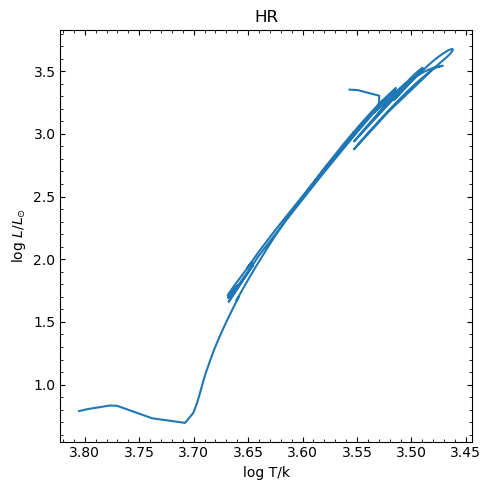

In [29]:
plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(h1.log_Teff, h1.log_L, label='start')
# idx = -650
# ax.plot(h2.log_Teff[:idx], h2.log_L[:idx], label='RGB&HB')
# ax.plot(h2.log_Teff[-650:-230], h2.log_L[-650:-230], label='start AGB')
# idx = -230
# ax.plot(h2.log_Teff[idx:], h2.log_L[idx:], label='to_end_agb')
# ax.plot(h3.log_Teff, h3.log_L, label='to_wd')
idx = 30
ax.plot(h2.log_Teff[idx:], h2.log_L[idx:], label='')
ax.set_title('HR')
ax.set_xlabel('log T/k')
ax.set_ylabel('log $L/L_{\odot}$')
ax_fmt(ax, 'HR', legend=True, savefig=False)

# invert the x-axis
ax.invert_xaxis()
# plt.gca().invert_xaxis()

In [30]:
print(x2[idx] - x2[0])
print(x2[-1] - x2[idx])
print(x2[-1] - x2[-650])

2737175976.744133
1113710932.063777
185506245.69765997


### log R

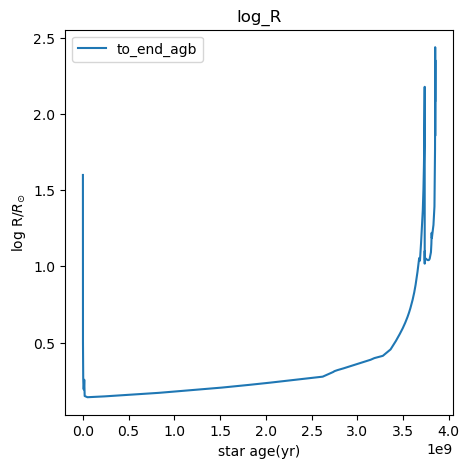

In [31]:
var = 'log_R'
y1 = getattr(h1, var)
y2 = getattr(h2, var)
y3 = getattr(h3, var)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# plt.plot(x1, y1, label='start')
ax.plot(x2, y2, label='to_end_agb')
# plt.plot(x3, y3, label='to_wd')
ax.legend()
ax.set_xlabel('star age(yr)')
ax.set_ylabel('log R/$R_{\odot}$')
ax.set_title(var)

max_logR = max(y2)

### Complete mass vs star_age plot

total time = 3.867874e+09 yr
total mass loss = 0.8475124385621277 $M_\odot$
equivalent linear mass loss rate = 2.191158094750846e-10 $M_\odot yr^-1$


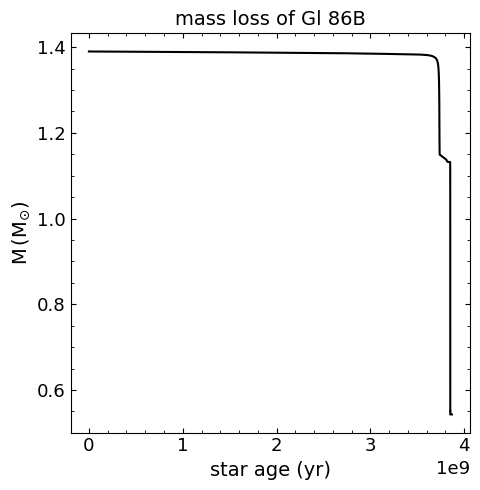

In [32]:
var = 'star_mass'
y1 = getattr(h1, var)
y2 = getattr(h2, var)
y3 = getattr(h3, var)

adjust_font()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x1, y1)
ax.plot(x2, y2, c='k')
ax.plot(x3, y3, c='k')
ax.set_title('mass loss of Gl 86B')
ax.set_xlabel('star age (yr)')
ax.set_ylabel(r'$\mathrm{M\,(M_{\odot})}$')
ax_fmt(ax, 'plots/primordial_orbit/Gl86B_m_vs_t')

del_age = h3.star_age[-1] - h1.star_age[0]
del_m = M2i - M2
mass_loss_rate = del_m/del_age
print('total time = {:e} yr'.format(del_age))
print(r'total mass loss = {} $M_\odot$'.format(del_m))
print('equivalent linear mass loss rate = {} $M_\odot yr^-1$'.format(mass_loss_rate))

In [33]:
print(y3)

[0.55030489 0.54824808 0.54596173 0.54512859 0.54485541 0.54470068
 0.54458161 0.54446394 0.54434185 0.54425809 0.54415157 0.54408197
 0.54399852 0.54388497 0.54374258 0.5435763  0.54340643 0.54326145
 0.54316746 0.54311372 0.54308164 0.54306827 0.54306391 0.54306337
 0.54306335 0.54306335 0.54306335 0.54306335 0.54306335 0.54306335
 0.54306335]


The average mass loss rate is then 4.507469e-09 $\M_odot/yr$, during this 1.855062e+08 yr stretch. Use this result for the mass loss in Mercury
1.3786511708534572


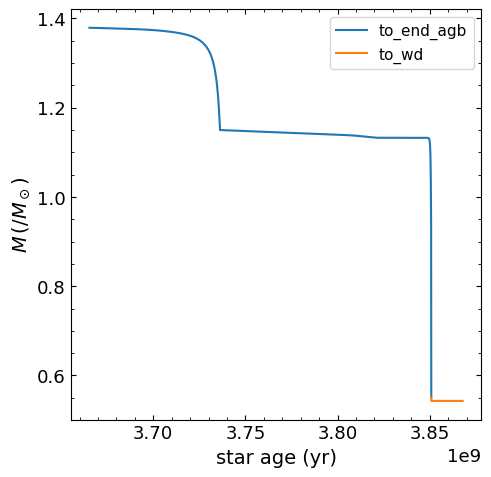

In [34]:
idx = -650
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x2[idx:], y2[idx:], label='to_end_agb')
ax.plot(x3, y3, label='to_wd')
ax.set_xlabel('star age (yr)')
ax.set_ylabel(r'$M\,(/M_\odot)$')
ax_fmt(ax, '', savefig=False)

del_m = y2[idx] - M2
del_age = x2[-1] - x2[idx]
mass_loss_rate = del_m/del_age
print("The average mass loss rate is then {:e} $\M_odot/yr$, during this {:e} yr stretch. Use this \
result for the mass loss in Mercury".\
      format(mass_loss_rate, del_age))

# the Mercury simulation might go slightly beyond this starting mass of the plot below. So, record 
# this starting mass and later use it as a truncation point in the Mercury analysis part.
# call it end_ because Mercury step is -1 (time goes backward)
end_simulation_mass = y2[idx]
print(end_simulation_mass)

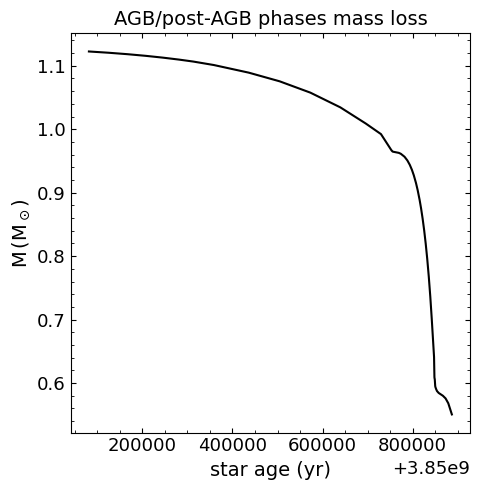

In [35]:
idx = -230
del_m = y2[idx] - y2[-1]
del_age = x2[-1] - x2[idx]

adjust_font()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x2[idx:], y2[idx:], c='k')
ax.set_xlabel('star age (yr)')
ax.set_ylabel(r'$\mathrm{M\,(M_\odot)}$')
ax.set_title('AGB/post-AGB phases mass loss')
ax_fmt(ax, 'plots/primordial_orbit/post_AGB_mGl86B_vs_t')

In [36]:
if break_MESA == True:
    sys.exit()

## Roche lobe

In [37]:
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook # this thing will stop images from showing up on the notebook,
                       # but it will let the Roche lobe plot become interactive?

# def roche_font():
    
#     plt.rcParams.update(plt.rcParamsDefault)
#     font = {
# #         'font.size': 15,   # this affects the axis label, text, and title
#         'axes.labelsize': 14, 
#         'axes.titlesize': 14, 
#         'xtick.labelsize': 13, 
#         'ytick.labelsize': 13,
#         'legend.fontsize': 11, 
#         'figure.dpi': 150,
#         'savefig.dpi': 500
# #         'axes.labelpad': 20
# #         'figure.titlesize': 15  # does not take effect
#     }
#     plt.rcParams.update(**font)
    
#     return 

# roche_font()

In [39]:
# add the primordial semi-major axis
a1i = aBi = (M1 + M2)*a1/(M1 + M2i)

print('check values', M1, M2i, a1i)

q = M2/M1
theta = np.linspace(0, 3.14, 100)
phi = np.linspace(0, 6.28, 100)
tt, pp = np.meshgrid(theta, phi)

f = open('Roche_lobe/InputqThePhi.txt', 'w')

for i in range(len(phi)):
    for j in range(len(theta)):
        f.write('{:<25}{:<25}{:<25}'.format(q, tt[i, j], pp[i, j]))
        f.write('\n')
f.close()

check values 0.87 1.39 14.832757971088395


Text(0.5, 0, 'z (AU)')

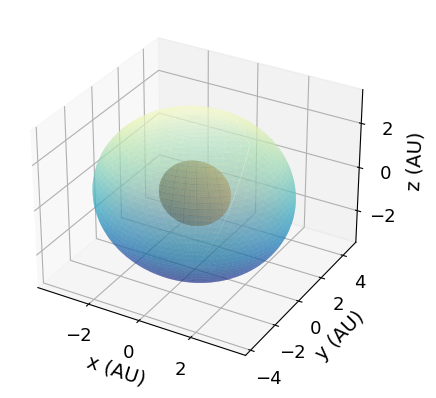

In [40]:
# constant
AU_Rsun_ratio = 215

theta = np.linspace(0, 3.14, 100)
phi = np.linspace(0, 6.28, 100)
tt, pp = np.meshgrid(theta, phi)

# load the results of radius of Roche lobe at every direction
R = np.loadtxt('Roche_lobe/qThePhiR.txt', usecols=3, unpack=True)
rr = np.zeros([len(phi), len(theta)])
for i in range(len(R)):
    rr[i//len(theta), i%len(theta)] = R[i]

# express the mesh in the Cartesian coordinates
x, y, z = rr*np.sin(tt)*np.sin(pp), rr*np.sin(tt)*np.cos(pp), rr*np.cos(tt)
# scale the coordinates up in terms of the minimum primordial separation
x *= a1i*(1 - e1)
y *= a1i*(1 - e1)
z *= a1i*(1 - e1)

# Plot the surface.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# fig, ax = plt.subplots(1, 1, projection='3d')   # not working

ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# plot the star inside the Roche lobe surface
# use r in AU. max_logR was defined in the MESA section
r = 10**max_logR/AU_Rsun_ratio
r *= np.ones([len(phi), len(theta)])
x1, y1, z1 = r*np.sin(tt)*np.sin(pp), r*np.sin(tt)*np.cos(pp), r*np.cos(tt)
ax.plot_surface(x1, y1, z1)
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
ax.set_zlabel('z (AU)')
# ax_fmt(ax, square=False, savefig=False)

In [41]:
fig.savefig('plots/primordial_orbit/Roche_lobe', bbox_inches='tight')

# Mercury

As a reminder to myself. Remember to change all the $m$ in Mercury section to Mb. 

In [42]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d

In [43]:
break_Mercury = False
adjust_font()

### Calculate the initial velocities and positions of Gl 86B and Gl 86Ab

In [44]:
G = 4*np.pi**2/365**2       # gravitational constant in terms of days

# mass_loss_rate = ...      # defined in the MESA section
time_offset = 4239667879    # the time of stellar evolution we assume the mass has not lost
                            # we assume the mass starts to lose rapidly at this time

def omega(M1, M2, a, e):
    
    return np.sqrt((1 - e)/(a**3*(1 + e)**3)*G*(M1 + M2))

# velocity in terms of AU/day
def v(omega, r):
    
    return omega*r

def v_extra(M1, Mb, a2, e2):
    '''
    The v_extra is caused by the presence of the planet. Because the planet's initial velocity is at +y,
    M1 has a -y velocity to ensure conseration of angular momentum. In Mercury, M1 is supposed to be stationary,
    so M2 should have an equal and opposite velocity at +y direction.
    '''
    v_Gl86Ab = v(omega(M1, Mb, a2, e2), r1(a2, e2))
    
    return Mb*v_Gl86Ab/M1

def r1(a, e):
    
    return a*(1 + e)

def r2(a, e):
    
    return a*(1 - e)

In [45]:
# The results here will go to the big.in file for mercury simulation

print('check values', M1, M2, a1, a2, e1, e2, Mb, '\n')
# initial position of Gl 86B
print(r1(a1, e1))
# initial velocity of Gl 86B 
print(v(omega(M1, M2, a1, e1), r1(a1, e1)) + v_extra(M1, Mb, a2, e2))
# initial position of Gl 86Ab
print(r1(a2, e2))
# initial velocity of Gl 86Ab
print(v(omega(M1, Mb, a2, e2), r1(a2, e2)))

check values 0.87 0.5424875614378722 23.73262174467242 0.11781950557148542 0.42861485672471167 0.047796623808232436 0.004666388504909734 

33.90477601346697
0.002895731218099085
0.12345088015655764
0.044712194521761235


In [47]:
file = 'mercury_results/Gl86B28.aei'

var_labels = ['time', 'a', 'e', 'i', 'g', 'n', 'l', 'p', 'q', 'b', 'x', 'y', 'z', 'u', 'v', 'w', 'r', 'f', 'm', 's']

time, a, e, x, y, mass = np.loadtxt(file, usecols=(0, 1, 2, 10, 11, 18), skiprows=4, unpack=True)
print(mass[0], mass[-1])
# let's see if the following command can be omitted
idx = mass <= end_simulation_mass     
time, a, e, x, y, mass = time[idx], a[idx], e[idx], x[idx], y[idx], mass[idx]
time *= 1000
time_raw = np.copy(time)

0.5424917 1.387662


### Find the evolution of secular semi-major axis/eccentricity vs. time

In [48]:
x0_list = []
t0_list = []

# When two consecutive points goes cross the x axis, record the x coordinate of the 
# intersection between the line going through these two points and the x axis.
# If one of points happen to be zero, x0_list appends the second point and change mark
# to be 1, so that at the next step, x0_list won't append anything.
mark = 0   

for i in range(len(x) - 1):
    if y[i + 1]*y[i] < 0:
        x0_list.append(-y[i]*(x[i] - x[i+1])/(y[i] - y[i+1]) + x[i])
        t0_list.append(time[i])
    elif y[i + 1]*y[i] == 0 and mark == 0:
        x0_list.append(x[i+1])
        t0_list.append(time[i])
        mark = 1
    elif y[i + 1]*y[i] == 0 and mark == 1:
        mark = 0
        
# check that all recorded x coordinates have alternating signs 
for i in range(len(x0_list) - 1):
    if x0_list[i]*x0_list[i + 1] < 0:
        pass
    else:
        print('x=0 when index=' + str(i))

t_list = []
a_list = []
e_list = []

def calc_e(mark, a, x):
    if mark == 0:
        return 1 - x/a
    else: 
        return x/a - 1
    
def calc_vars_list():
    '''
    mark = 0 means the first element in the x0_list is periapsis and e is calculated from peripapsis = a*(1 - e)
    mark = 1 means the first element in the x0_list is apoapsis and e is calculated from apoapsis = a*(1 + e)
    '''
    if x0_list[0] < 0:
        mark = 0
    else:
        mark = 1
    for i in range(0, len(x0_list) - 1, 2):
        a = (x0_list[i] - x0_list[i + 1])/2
        a_list.append(a)
        e_list.append(calc_e(mark, a, abs(x0_list[i])))
        t_list.append(t0_list[i])

calc_vars_list()

In [1]:
# Here, I found list + float64 = nparray, but list + float is not addable
# The way I was doing t_list + abs(min(t_list)) should have been avoided

# a_theory = a1*M_tot/(M_tot - mass_loss_rate*np.array(t_list))
# m_tmp = M_tot - mass_loss_rate*np.array(t_list)
# # print(t_list)
# print(m_tmp[-1])
# print(a_theory[-1])
# print('check values', a1, M_tot, mass_loss_rate)
# t = t_list + abs(min(t_list)) + time_offset

# fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.plot(time, a_list, c='y', label='simulation')
# ax.plot(time, a_theory, linestyle='--', c='k', label=r'$\mathrm{M_{tot}\,a=}$constant')
# ax.legend()
# ax.set_xlabel('star age (yr)')
# ax.set_ylabel('semi-major axis (AU)')
# ax.margins(0, 0)
# ax_fmt(ax, 'plots/primordial_orbit/evo_a')

In [2]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(time, e_list, c='y', label='simulation')
# ax.axhline(y=e_list[0], color='k', linestyle='--', label=r'$\mathrm{\left<\frac{de}{dt}\right>}=0$')
# ax.set_xlabel('star age (yr)')
# ax.set_ylabel('eccentricity')
# ax.margins(0, 0)
# ax.set_ylim(e1 - 0.07, e1 + 0.07)
# ax_fmt(ax, 'plots/primordial_orbit/evo_e')

### Plot the orbits of the Gl86B with respect to Gl86A

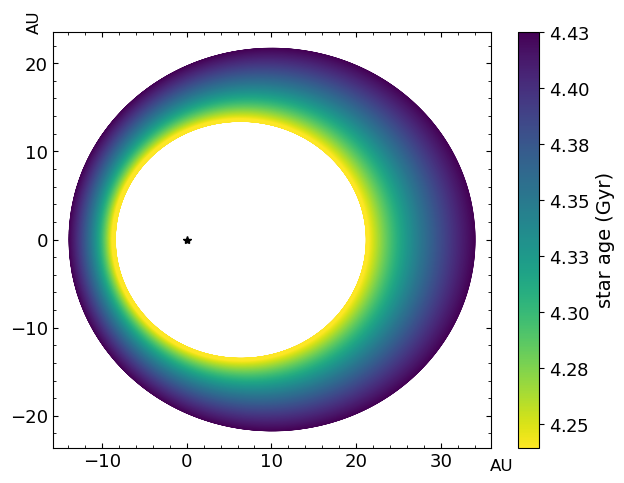

In [51]:
# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(1, 1)

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${}$'.format(a)

# Create a continuous norm to map from data points to colors
# norm = plt.Normalize(0, 1000*(len(x)-1))
norm = plt.Normalize(time_offset/1e9, time_offset/1e9 + abs(min(time_raw))/1e9)
lc = LineCollection(segments, cmap='viridis_r', norm=norm)
# Set the values used for colormapping
# lc.set_array(np.linspace(1000*(len(x)-1), 0, len(x)-1))
lc.set_array(np.linspace(time_offset/1e9 + abs(min(time_raw))/1e9, time_offset/1e9, len(time_raw)))
lc.set_linewidth(2)
line = axs.add_collection(lc)
cb = fig.colorbar(line, ax=axs, format=ticker.FuncFormatter(fmt))
cb.ax.set_ylabel('star age (Gyr)')

axs.plot(0, 0, marker='*', c='k')
axs.set_xlim(x.min()-2, x.max()+2)
axs.set_ylim(y.min()-2, y.max()+2)
# axs.set_xlabel('AU')
# axs.set_ylabel('AU')

ax = plt.gca()
label = ax.set_xlabel('AU', fontsize=12)
ax.xaxis.set_label_coords(1.025, -0.025)

ax = plt.gca()
label = ax.set_ylabel('AU', fontsize=12, rotation=90)
ax.yaxis.set_label_coords(-0.025, 1.025)

ax_fmt(ax, 'plots/primordial_orbit/Gl86B_orbit', square=False)

In [52]:
if break_Mercury == True:
    sys.exit()

# Disk Mass

I have changed all the $M2$ to $M2i$ and $a$ to $ai$ in this Disk Mass section. 

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import sin, cos, tan, pi, sqrt, log10, arctan
from scipy.integrate import quad, dblquad
from scipy.optimize import fsolve
from scipy.misc import derivative
from scipy.interpolate import interp2d
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import LogLocator
import time

In [54]:
# a help function that forces figures (with colorbar) square

import matplotlib.colors as colors
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

class RemainderFixed(axes_size.Scaled):
    def __init__(self, xsizes, ysizes, divider):
        self.xsizes = xsizes
        self.ysizes = ysizes
        self.div = divider

    def get_size(self, renderer):
        xrel, xabs = axes_size.AddList(self.xsizes).get_size(renderer)
        yrel, yabs = axes_size.AddList(self.ysizes).get_size(renderer)
        bb = Bbox.from_bounds(*self.div.get_position()).transformed(self.div._fig.transFigure)
        w = bb.width/self.div._fig.dpi - xabs
        h = bb.height/self.div._fig.dpi - yabs
        return 0, min([w, h])

def make_square_axes_with_colorbar(ax, size=0.1, pad=0.1):
    """ Make an axes square, add a colorbar axes next to it, 
        Parameters: size: Size of colorbar axes in inches
                    pad : Padding between axes and cbar in inches
        Returns: colorbar axes
    """
    divider = make_axes_locatable(ax)
    margin_size = axes_size.Fixed(size)
    pad_size = axes_size.Fixed(pad)
    xsizes = [pad_size, margin_size]
    yhax = divider.append_axes("right", size=margin_size, pad=pad_size)
    divider.set_horizontal([RemainderFixed(xsizes, [], divider)] + xsizes)
    divider.set_vertical([RemainderFixed(xsizes, [], divider)])
    return yhax

In [55]:
# global constants 
G = 4*pi**2
k = 3.06e-61       # Boltzmann constant in terms of AU, yr, Msun, and K
m_p = 8.33e-58     # mass of proton in terms of solar mass
Z = 0.01           # metallicity
mu_ave = 2.3*m_p   # mean molecular weight

# a1i was defined in the Roche lobe section

In [56]:
def M_disk(rmin, rmax, Z, M_dot, alpha=None, Reynolds=None):
            
    return quad(M_disk_integrand, rmin, rmax, args=(Z, M_dot, alpha, Reynolds))
    
mu_ave = 2.3*m_p   # mean molecular weight

mu_ave = 2.3*m_p   # mean molecular weight

# a1i was defined in the Roche lobe section
# a1i was defined in the Roche lobe section
def M_disk_integrand(r, Z, M_dot, alpha, Reynolds):
    
    # sigma is the surface density of the gas
    if alpha == None:
        sigma = M_dot*Reynolds/(3*pi*sqrt(G*(M1 + M2i)*r))
    elif Reynolds == None:
        sigma = M_dot*mu_ave / (3*pi*alpha*k * Temp(r, Z, M_dot) * sqrt(r**3*(M1 + M2i)/G) / M1)
    
    return 2*pi*r*sigma

# Toomre parameter
def Q(M1, M2, T, r, M_dot, Rey):
    '''
    r is the position where you want to check the value of Q
    '''
    
    return 3*np.sqrt(k/mu_ave*Temp(r, Z, M_dot))*(M1 + M2)/(M_dot*Rey*r)
    
def Temp(r, Z, M_dot):   # use Temp to distinguish the T function in phi_ml
    
    if 1.75e-8 < M_dot:
        M_dot_ref = 3.5e-8
    elif 8.75e-9 < M_dot <= 1.75e-8:
        M_dot_ref = 1.75e-8
    elif M_dot <= 8.75e-9:
        M_dot_ref = 8.75e-9
    
    mu_R = log10(M_dot/M_dot_ref)
    chi = log10(100*Z/0.5) / log10(2)
    
    if Z < 0.005: 
        if M_dot > 1.75e-8:
            pass
        elif 8.75e-9 < M_dot <= 1.75e-8:
            pass
        elif M_dot <= 8.75e-9:
            pass
    
    elif Z >= 0.005:
        if M_dot > 3.5e-8:
            A1, A2, A3 = 410*1.175**chi, 650*1.15**chi, 185*1.025**chi
            B1, B2, B3 = 1.3*1.2**chi, 1.8*1.15**chi, 1.4*1.05**chi
            val = A1 * B1**mu_R * r**(-6/7. - log10(100*Z + 0.5)/4) * psi(r, Z, '12', M_dot, mu_R, chi) \
                + A2 * B2**mu_R * r**(-8/7.) * psi(r, Z, '21', M_dot, mu_R, chi) * psi(r, Z, '23', M_dot, mu_R, chi) \
                + A3 * B3**mu_R * r**(-4/7.) * psi(r, Z, '32', M_dot, mu_R, chi)
        elif 1.75e-8 < M_dot <= 3.5e-8:
            A1, A2, A3 = 410*1.175**chi, 650*1.15**chi, 185*1.025**chi
            B1, B2, B3 = 3.0*0.9**chi, 2.1*1.15**chi, 1.176*1.05**chi
            val = A1 * B1**mu_R * r**(-6/7. - log10(100*Z + 0.5)/4) * psi(r, Z, '12', M_dot, mu_R, chi) \
                + A2 * B2**mu_R * r**(-8/7.) * psi(r, Z, '21', M_dot, mu_R, chi) * psi(r, Z, '23', M_dot, mu_R, chi) \
                + A3 * B3**mu_R * r**(-4/7.) * psi(r, Z, '32', M_dot, mu_R, chi)
        elif 8.75e-9 < M_dot <= 1.75e-8:
            A1, A2, A3 = 410*(3*0.9**chi)**log10(0.5)*1.175**chi, 650*(2.1*1.15**chi)**log10(0.5)*1.15**chi, \
                        185*(1.176*1.05**chi)**log10(0.5)*1.025**chi
            B1, B2, B3 = 8.0*1.2**chi, 30.0*(1.2 - chi/(chi + 3))**chi, 2.2*0.9**chi
            val = A1 * B1**mu_R * r**(-6/7. - log10(100*Z + 0.5)/4 * (1 - mu_R/log10(0.5))) * psi(r, Z, '12', M_dot, mu_R, chi) \
                + A2 * B2**mu_R * r**(-8/7.) * psi(r, Z, '21', M_dot, mu_R, chi) * psi(r, Z, '23', M_dot, mu_R, chi) \
                + A3 * B3**mu_R * r**(-4/7. - mu_R*(1/(100*Z))/8) * psi(r, Z, '32', M_dot, mu_R, chi)
        elif M_dot <= 8.75e-9:
            A1, A2, A3 = 410*(3*0.9**chi)**log10(0.5)*(8*1.2**chi)**log10(0.5)*1.175**chi, \
                        650*(2.1*1.15**chi)**log10(0.5), \
                        185*(1.176*1.05**chi)**log10(0.5)*(2.2*0.9**chi)**log10(0.5)*1.025**chi
            B1, B2, B3 = 2.0*1.4**chi, 1.5*1.8**chi, 1.9*0.9**chi
            val = A1 * B1**mu_R * r**(-6/7.) * psi(r, Z, '12', M_dot, mu_R, chi) \
                + A2 * B2**mu_R * r**(-8/7.) * psi(r, Z, '21', M_dot, mu_R, chi) * psi(r, Z, '23', M_dot, mu_R, chi) \
                + A3 * B3**mu_R * r**(-4/7. - log10(0.5)*(1/(100*Z))/8) * psi(r, Z, '32', M_dot, mu_R, chi)
    
    return val

# the factor psi expresses the transition from regime i to regime j
def psi(r, Z, trans, M_dot, mu_R, chi):   # need to add M_dot to the arguments
    
    if Z < 0.005: 
        if trans == '12':
            pass
        elif trans == '21':
            pass
        elif trans == '23':
            pass
        elif trans == '32':
            pass
        
    elif Z >= 0.005:
        if 3.5e-8 < M_dot:
            if trans == '12':
                sign, a, b, c, d = -1, 3.0, 1.832, 0.15, 0.55
            elif trans == '21':
                sign, a, b, c, d = 1, 2.6, 1.832, 0.1666, 0.666
            elif trans == '23':
                sign, a, b, c, d = -1, 8.3, 1.732, 0.20, 1
            elif trans == '32':
                sign, a, b, c, d = 1, 8.3, 1.732, 0.20, 1
            val = (sign*arctan(r - a*(b**mu_R + (c + d*mu_R**2)*chi)) + pi/2)/pi
        elif 1.75e-8 < M_dot <= 3.5e-8:
            if trans == '12':
                sign, a, b, c, d = -1, 3.0, 1.832, 0.15, -0.4
            elif trans == '21':
                sign, a, b, c, d = 1, 2.6, 1.832, 0.1666, -0.5
            elif trans == '23':
                sign, a, b, c, d = -1, 8.3, 1.732, 0.20, -1.5
            elif trans == '32':
                sign, a, b, c, d = 1, 8.3, 1.732, 0.20, -1.5
            val = (sign*arctan(r - a*(b**mu_R + (c + d*mu_R**2)*chi)) + pi/2)/pi
        elif 8.75e-9 < M_dot <= 1.75e-8:
            if trans == '12':
                sign, a, c, d, e = -1, 3.0, -0.2, 2, 3
            elif trans == '21':
                sign, a, c, d, e = 1, 2.6, -0.2, 2, 5
            elif trans == '23':
                sign, a, c, d, e = -1, 8.3, 1, 1, 3 
            elif trans == '32':
                sign, a, c, d, e = 1, 8.3, 1, 1, 3.5 
            val = (sign*arctan(r - a*R(Z, M_dot, trans, chi)*(c*chi**d + e)**mu_R) + pi/2)/pi
        elif M_dot <= 8.75e-9:   
            if trans == '12':
                sign, a, b, c, d, e = -1, 3.0, 0, 0, 0, 3
            elif trans == '21':
                sign, a, b, c, d, e = 1, 2.6, 0, 0, 0, 5
            elif trans == '23':
                sign, a, b, c, d, e = -1, 8.3, -2, 0.1, 1, 0 
            elif trans == '32':
                sign, a, b, c, d, e = 1, 8.3, -2, 0.2, 2, 0
            val = (sign*arctan(r - a*R(Z, M_dot, trans, chi)*(b*mu_R + c*chi**d + e)**mu_R) + pi/2)/pi
        
    return val

# reduction factors
def R(Z, M_dot, trans, chi):
    
    if Z < 0.005:
        pass
    
    elif Z >= 0.005:
        if 8.75e-9 < M_dot <= 1.75e-8:
            if trans == '12':
                val = 1.832**(log10(0.5)) + (0.15 - 0.4*(log10(0.5))**2)*chi
            elif trans == '21':
                val = 1.832**(log10(0.5)) + (0.1666 - 0.5*(log10(0.5))**2)*chi
            elif trans == '23':
                val = 1.372**(log10(0.5)) + (0.2 - 1.5*(log10(0.5))**2)*chi
            elif trans == '32':
                val = 1.372**(log10(0.5)) + (0.2 - 1.5*(log10(0.5))**2)*chi
        elif M_dot <= 8.75e-9:
            if trans == '12':
                val = 1.832**(log10(0.5)) + (0.15 - 0.4*(log10(0.5))**2)*chi * (3 - 0.2*chi**2)**log10(0.5)
            elif trans == '21':
                val = 1.832**(log10(0.5)) + (0.1666 - 0.5*(log10(0.5))**2)*chi * (5 - 0.2*chi**2)**log10(0.5)
            elif trans == '23':
                val = 1.372**(log10(0.5)) + (0.2 - 1.5*(log10(0.5))**2)*chi * (3 + chi)**log10(0.5)
            elif trans == '32':
                val = 1.372**(log10(0.5)) + (0.2 - 1.5*(log10(0.5))**2)*chi * (3.5 + chi)**log10(0.5)
            
    return val

### Compare the disk mass with those calculated in Jang-Condell 2007

In [57]:
Condell = np.array([
    [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-1, 1e-1, 1e-1, 1e-1],
    [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-4, 1e-5, 1e-6, 1e-7],
    [3e-1, 7e-2, 1.6e-2, 3.8e-3, 8.7e-4, 1.9e-4, 5.8e-2, 1.3e-2, 3e-3, 7e-4, 1.6e-4, 1.1e-2, 2.6e-3, 5.9e-4, 1.3e-4],
    [2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 2.3, 2.2, 2.0, 1.9, 1.8, 2.7, 2.5, 2.3, 2.2]
])

print('{:8} {:10} {:11} {:11} \n'.format('alpha', 'M_dot', 'calcualted', 'Jang-Condell2007'))
for i in range(len(Condell[0])):
    alpha = Condell[0][i]
    M_dot = Condell[1][i]
    m_JC = Condell[2][i]
    r_tr = Condell[3][i]
    m = M_disk(0.4, r_tr, Z, M_dot, alpha=alpha)[0]
    print('{:5.2e} {:5.2e} {:10.2e} {:10.2e}'.format(alpha, M_dot, m, m_JC))

alpha    M_dot      calcualted  Jang-Condell2007 

1.00e-03 1.00e-04   1.12e+00   3.00e-01
1.00e-03 1.00e-05   1.59e-01   7.00e-02
1.00e-03 1.00e-06   2.24e-02   1.60e-02
1.00e-03 1.00e-07   3.07e-03   3.80e-03
1.00e-03 1.00e-08   7.32e-04   8.70e-04
1.00e-03 1.00e-09   1.04e-04   1.90e-04
1.00e-02 1.00e-04   1.39e-01   5.80e-02
1.00e-02 1.00e-05   2.00e-02   1.30e-02
1.00e-02 1.00e-06   2.65e-03   3.00e-03
1.00e-02 1.00e-07   3.66e-04   7.00e-04
1.00e-02 1.00e-08   8.79e-05   1.60e-04
1.00e-01 1.00e-04   1.77e-02   1.10e-02
1.00e-01 1.00e-05   2.44e-03   2.60e-03
1.00e-01 1.00e-06   3.30e-04   5.90e-04
1.00e-01 1.00e-07   4.60e-05   1.30e-04


In [58]:
# This code focuses on mu_star = 1 (circumprimary disk) and j = 2 (torque contributed by the companion)

Omega_B = sqrt(G*(M1 + M2i)/a1i**3)   # mean motion
per = 2*pi/Omega_B   # period

# expressions of eq16_LSH, eq16_RHS, and r_tr

# the left-hand side of eq.(16), which measures the viscosity stress
def eq16_LHS(Reynolds=None, r=None, Z=None, M_dot=None, alpha=None):
    
    if Reynolds == None:
        H_over_r = sqrt(Temp(r, Z, M_dot) * r/(G*M1) * k/mu_ave)
        val = sqrt(alpha)*np.mean(H_over_r)
    else:
        val = Reynolds**(-1/2.)

    return val

# the right_hand side of eq.(16), which measures the resonant torque
def eq16_RHS(r_tr_type, disk_type, m, l, e, a, use_eq78):

    if disk_type == 'primary':
        j = 2
        mu_star = mu(1)
        disk_type_sign = -1
    elif disk_type == 'secondary':
        j = 1
        mu_star = mu(2)
        disk_type_sign = -1
    elif disk_type == 'binary':
        mu_star = 1
        disk_type_sign = 1
    
    if r_tr_type == 'ILR':
        r_tr = r_ILR(m, l, mu_star, a)
    elif r_tr_type == 'OLR':
        r_tr = r_OLR(m, l, mu_star, a)
    elif r_tr_type == 'CR':
        r_tr = r_CR(m, l, mu_star, a)
    
    # for lambda = [dln(phi)/dln(r)]_{LR}. Artymowicz & Lubow 1994 did not mention how to calculate 
    # lambda for CR
    if m > 1 and r_tr_type == 'ILR' and disk_type in ('primary', 'secondary'):
        lamb = m
    elif r_tr_type == 'OLR' and disk_type == 'binary':
        lamb = -(m + 1)
    else:
        raise ValueError('only either m > 1 & ILR in circumstellar disk, or OLR in circumbinary disk is available')

    val = a*abs(phi_ml(j, m, l, e, a, r_tr, use_eq78))/(G*(M1 + M2i)) \
        * (pi*m)**(1/2.)*(m + disk_type_sign)**(1/6.)*abs(lamb - disk_type_sign*2*m) \
        / (3*mu_star**(2/3.)*l**(2/3.))

    return val

# positions/radii at which inner and outer Lindblad (LR) and corotational (CR) resonances.

def r_CR(m, l, mu_star, a):    
    
    return (m/l)**(2/3.) * mu_star**(1/3.) * a

def r_ILR(m, l, mu_star, a):
    
    return ((m - 1)/l)**(2/3.) * mu_star**(1/3.) * a

def r_OLR(m, l, mu_star, a):
    
    return ((m + 1)/l)**(2/3.) * mu_star**(1/3.) * a

##########################################################################

# phi_ml and its help funcitons

# let the r in Artymowicz & Lubow be r0, and r_j(t) be r(j, t)
# r0 is then the point wherever you want to know the phi_ml/torque
# let the default r0 be the closest approach of the two stars. i.e., r0 = a*(1 - e)
# Omega_B is the mean motion, i.e., Omega_B = sqrt(G*M/a**3)
def phi_ml(j, m, l, e, a, r_tr, use_eq78=False):
    
    return dblquad(phi_ml_integrand, 0, pi, lambda t: 0, lambda t: per/2, \
                   args=(j, m, l, e, a, r_tr, use_eq78))[0]

def phi_ml_integrand(t, phi, j, m, l, e, a, r_tr, use_eq78=False):

    return (-1)**(m*j + 1)*2*mu(j)*G*(M1 + M2i)/r_tr * Omega_B/pi**2 * \
            T(t, m, l, e, use_eq78)*B(t, phi, j, m, e, a, r_tr, use_eq78)

# eq.(5) of Artymowicz & Lubow 1994. It has nothing to do with temperature.
# There's another function T at the beginning of Gl_86.ipynb
def T(t, m, l, e, use_eq78=False):

    if use_eq78 == False:
        return cos((m - l)*Omega_B*t + m*(f(t, e) - Omega_B*t))
    elif use_eq78 == True:
        return cos( (m - l)*Omega_B*t + m*(2*e*sin(Omega_B*t) + 5*e**2/4*sin(2*Omega_B*t)) )

# eq.(6) of Artymowicxs & Lubow 1994
def B(t, phi, j, m, e, a, r_tr, use_eq78=False):

    return cos(m*phi)/(1 - 2*q(j, t, e, a, r_tr, use_eq78)*cos(phi) \
                       + q(j, t, e, a, r_tr, use_eq78)**2)**(1/2.)

def q(j, t, e, a, r_tr, use_eq78=False):

    if use_eq78 == False:            
        r = a*(1 - e**2)/(1 + e*cos(f(t, e)))
        return r/r_tr
    elif use_eq78 == True:
        return s(j, r_tr)*(1 - e*cos(Omega_B*t) - e**2/2*(cos(2*Omega_B*t) - 1) \
                      *(cos(3*Omega_B*t) - cos(Omega_B*t)))

# true anomaly
def f(t, e):

    E = fsolve(kepler_eq, Omega_B*t, args=(t, e))[0]
    
    return 2*arctan(sqrt((1 + e)/(1 - e)) * tan(E/2))

def kepler_eq(E, t, e):

    return E - e*np.sin(E) - Omega_B*t

def s(j, r_tr):   
    
    # For circumstellar disk, the origin is centered on the appropriate star. 
    # For this star, a_j is 0, so for the other star, the a_j = a.
    return a/r_tr

def mu(j):    
    
    if j == 1:
        return M1/(M1 + M2i)
    elif j == 2: 
        return M2i/(M1 + M2i)   

The sampling result of ai is 15.06 -1.522 +1.839 AU
The median initial semimajor axis is 15.14 AU


In [204]:
# help functions for error propagation

np.random.seed(1)

def draw_par(pars, draws):
    """
    Draw parameters from the MCMC sampling `draws` times.
    Returns the samples for each parameter
    Parameters
    ----------
    pars : array_like[ndim,]
        The keywords of the parameters to be drawn from MCMC sampling
    """
    result = np.zeros([len(pars), draws])
    for i, par in enumerate(pars):
        for j in range(draws):
            result[i, j] = np.random.choice(chain_after_burnin[par], 1)
    return result

def draw_IFMR(draws):
    """
    Draw the coefficients of the IFMR `draws` times
    Let M_f = k*M_i + b, and draw k and b
    """
    result = np.zeros([2, draws])
    for i in range(draws):
        result[0, i] = np.random.normal(0.109, 0.007, 1)
        result[1, i] = np.random.normal(0.394, 0.025, 1)
    return result

def draw_ai(MA, MB, a, k, b):
    """
    Find initial semi-major axis, return the 16th, 50th, and 84th percentile
    Parameters
    ----------
    MA, MB, a, k, b : array_like[ndim,]
        Randomly drawn parameters
        MA and MB are the mass at present
    """
    MAi, MBi = MA, (MB - b)/k
    ai = (MA + MB)*a/(MAi + MBi)
    
    return ai

def draw_r_over_a(m, l, MA, MB):
    """
    Use the MCMC sampling to find errorbars of resonance radii
    Return the 16th, 50th, and 84th percentile
    For Figure 9(a)
    """
    mu_star = MA/(MA + MB)
    r_over_a = ((m - 1)/l)**(2/3)*mu_star**(1/3)
    
    return r_over_a

def draw_rtr(m, l, MA, MB, a):
    """
    Use the MCMC sampling to find errorbars of the truncation radii
    Return the 16th, 50th, and 84th percentile
    For Figure 9(b)
    """    
    mu_star = MA/(MA + MB)
    
    return r_ILR(m, 1, mu_star, a)

draws = 1000
MA, MB, a = draw_par(['mpri', 'msec0', 'sau0'], draws)
k, b = draw_IFMR(draws)
MAi, MBi = MA, (MB - b)/k

ai_low, ai, ai_high = np.percentile(draw_ai(MA, MB, a, k, b), [16, 50, 84])
m, l = 2, 3
r_over_a_low, r_over_a, r_over_a_high = np.percentile(draw_r_over_a(m, l, MAi, MBi), [16, 50, 84])
print("The sampling result of ai is {1:.4g} -{0:.4g} +{2:.4g} AU"
      .format(ai - ai_low, ai, ai_high - ai))
print("The median initial semimajor axis is {:.4g} AU"
      .format((0.87 + 0.54)*23.73/(0.87 + (0.54 - 0.394)/0.109)))

print("The sampling of r/a is {1:.4g} -{0:.4g} +{2:.4g}"
      .format(r_over_a - r_over_a_low, r_over_a, r_over_a_high - r_over_a))

# """
# later in def Fig5()
# call `draw_r_over_a(m, l, MAi, MBi)` and `draw_rtr(m, l, MAi, MBi, ai)`,
# more explicitly, set
# r_over_a_err = np.percentile(draw_r_over_a(m, l, MAi, MBi), [16, 50, 84]) for 9(a)
# rtr_err = np.percentile(draw_rtr(m, l, MAi, MBi, ai), [16, 50, 84]) for 9(b)
# Use the median as y, and 16th percentile and 84 percentile as lower and upper errorbarb
# """

The sampling result of ai is 15.03 -1.506 +1.858 AU
The median initial semimajor axis is 15.14 AU
The sampling of r/a is 0.351 -0.01174 +0.01398


In [258]:
# for Gl 86. Maybe rename it to def rtr_vs_e()
def fig5(a, m, r_tr_type, disk_type, rey_list, l_list, e_range, l_list_extra=None, start_circle=0, 
         use_eq78=False, break_e_Gl86=False, colors=None, title='', fname='rtr_vs_e', 
         rtr_err=False, less_ml_label=False, stop_at_rtr=False, draws=1000):
    '''
    Pass a to the argument. Later when call fig5, a should be a1i.
    e_range should be a tuple. It specifies the min and max e that can be tried in eq16.
    l_list_extra is some additional l values to try.
    The increasement for l_plus_list can be 10 instead of 1, for example.
    if break_e_Gl86=True, then the program stops calculating when ...TBD...
    change `start_circle` in range to decide which squares to circle
    Parameters
    ----------
    rtr_err : Boolean
        If True, will add truncation radii's error bars
    '''

    start = time.time()
    
    if stop_at_rtr == True:
        pass
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
    try:
        l_list += l_list_extra
    except:
        pass
        
    # could have combined e_arr and r_over_a into one thing, like r_tr below
    e_arr = np.zeros([len(rey_list), len(l_list)])   
    r_over_a = np.zeros([len(rey_list), len(l_list)])
    r_over_a_err = np.zeros([len(rey_list), 2, len(l_list)])
    
    # `r_tr` has shape (2, len(rey_list)).
    # r_tr[1, :] contains the truncation radii in the case of Gl 86. 
    # r_tr[0, :] are their correspoinding eccentricity on the plot.
    r_tr = np.zeros([2, len(rey_list)])   

    for i, rey in enumerate(rey_list):
        lhs = eq16_LHS(Reynolds=rey)
        e_start, e_end = e_range
        
        for j, l in enumerate(l_list):
            
            for e in np.arange(e_start, e_end, 0.01):
                rhs = eq16_RHS(r_tr_type, disk_type, m, l, e, a, use_eq78)
                
                if rhs >= lhs:
                    e_arr[i, j] = e
                    # instead of using the exact value of r_over_a, use the median of the drawn sample to plot
                    # r_over_a[i, j] = r_ILR(m, l, mu(1), a)/a
                    MA, MB= draw_par(['mpri', 'msec0'], draws)
                    k, b = draw_IFMR(draws)
                    MAi, MBi = MA, (MB - b)/k
                    per_16, r_over_a[i, j], per_84 = \
                        np.percentile(draw_r_over_a(m, l, MAi, MBi), [16, 50, 84])
                    r_over_a_err[i, 0, j], r_over_a_err[i, 1, j] = r_over_a[i, j] - per_16, \
                        per_84 - r_over_a[i, j]

                    # e_start = e instead of starting from e_range[0] to save time,
                    # because we know the e_tr for the next l should not be smaller than the previous e_tr
                    e_start = e
                    
                    # record the truncation radius under each Reynolds number and its corresponding e 
                    # we will use circles to show these points
                    if e_Gl86 >= e:
                        r_tr[0, i] = e
                        r_tr[1, i] = r_ILR(m, l, mu(1), a)/a
                    
                    break
        
        if stop_at_rtr == True:
            continue
        else:  
            # plot the resonance points
            # use data masking to avoid plotting those (e, r/a) = (0, 0) points
            # e = 0 means the program is not able to find an e such that rhs >= lhs
            if colors == None:
                mask = e_arr[i] != 0
                x = e_arr[i][mask]
                y = r_over_a[i][mask]
                yerr = err = np.array([r_over_a_err[i, 0][mask], r_over_a_err[i, 1][mask]])
                ax.errorbar(x, y, yerr, \
                            marker='s', capsize=2, ls=':', label='{:.0e}'.format(rey))
            else:
                ax.errorbar(x, y, yerr, c=colors[i], \
                            marker='s', capsize=2, ls=':', label='{:.0e}'.format(rey))                
    
    if stop_at_rtr == True:
        return r_tr
    
    print('e', r_tr[0])
    print('r_tr', r_tr[1])
    
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # add (m, l) text to the right of the plot
    ax.text(x_max, 1.02*y_max, '(m, l)', fontsize='medium', va='center')
    if less_ml_label == True:
        # only label (m, l) for those who are circled 
        for l in l_list:
            if r_ILR(m, l, mu(1), a)/a in r_tr[1]:
                ax.text(x_max, r_ILR(m, l, mu(1), a)/a, '({:}, {:})'.format(m, l), fontsize='medium', va='center')
    else:
        # label every (m, l)
        for l in l_list:
            ax.text(x_max, r_ILR(m, l, mu(1), a)/a, '({:}, {:})'.format(m, l), fontsize='medium', va='center')

    # circle those truncation radii
    for i in range(start_circle, len(r_tr[0])):
        ax.scatter(r_tr[0][i], r_tr[1][i], s=100, facecolor='none', edgecolor='k', zorder=100)
        
    # title text
    if title == '' and disk_type in ('primary', 'secondary'):
        title = 'circum' + 'stellar' + r', $\mathrm{M_2/(M_1 + M_2)}$ = ' + '{:.2f}'.format(M2i/(M1 + M2i))
    else: 
        title = title

    ax.set_title(title)
    ax.set_xlim(x_min, x_max + 0.15*(x_max - x_min))
    ax.set_ylim(y_min, y_max + 0.1*(y_max - y_min))
    ax.axvline(x=e_Gl86, c='grey', lw=1)
    ax.set_xlabel('e')
    ax.set_ylabel(r'$\mathrm{r_{tr}/a}$')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='both', which='both', direction="in", left=True, right=True, bottom=True, top=True)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    fig.tight_layout()
    fig.savefig('plots/planet_formation/' + fname, bbox_inches='tight')

    end = time.time()
    print('{:.2f} s'.format(end - start))
    return r_tr

def rtr_vs_Rey(r_tr_type, disk_type, reys, reys_scatter_fre, m, ls, e, a, use_eq78=False, title='',
               fname='rtr_vs_R', only_plot=True, only_rtr=False, both_plot_rtr=False):
    '''
    plot rtr vs. Reynolds at a given e, when plot = True
    `ls` is a list/array of l
    `reys_scatter_fre` is how often the rtr vs Reynolds is made as scatter marks
    '''

    start = time.time()
    
    rtr = np.zeros(len(reys))
    # starting from the largest l because the larger the l, the smaller the radius and therefore the 
    # smaller the torque. 
    # Because the Reynolds number list starts from the largest one (1e14), which corresponds to the 
    # smallest viscous stress, so we should try the largest l first (weakest torque), and then gradually
    # increase the l.
    l_start, l_end = ls[-1], ls[0]
    
    for i, rey in enumerate(reys):
        lhs = eq16_LHS(Reynolds=rey)

        for l in range(l_start, l_end - 1, -1):       
            rhs = eq16_RHS(r_tr_type, disk_type, m, l, e, a, use_eq78)
            
            if rhs >= lhs:
                rtr[i] = r_ILR(m, l, mu(1), a)/a
                l_start = l
                break

    end = time.time()
    print('{:.2f} s'.format(end - start))
    
    if only_rtr == True:
        return rtr
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.semilogx(reys, rtr*a, c='k', linestyle='--')
        ax.scatter(reys[::reys_scatter_fre], rtr[::reys_scatter_fre]*a, c='k')
        ax.set_title(title)
        ax.set_xlabel('Reynolds number')
        ax.set_ylabel(r'$\mathrm{r_{tr}}$ (AU)')
        # The solution I find to activate the minor tick in log scale is to set numticks a 
        # large number. `numticks` is the maximum number of ticks allowed to plot
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8,1.0), 
                                              numticks=100))
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='both', direction="in", left=True, right=True, bottom=True, top=True)
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        ax.text(1e10, 0.8*y_max, 'e = {:.3g}'.format(e), fontsize='medium', va='center', 
                color='black', size='large',
                bbox=dict(facecolor='none', edgecolor='black', pad=10.0))
        fig.tight_layout()
        fig.savefig('plots/planet_formation/' + fname, bbox_inches='tight')
        fig.show()
        
        if only_plot == True:
            return
        elif both_plot_rtr:
            return rtr

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
font = {
#     'font.size': 15,   # this affects the axis label, text, and title
    'axes.labelsize': 15, 
    'axes.titlesize': 13,
    'xtick.labelsize': 13, 
    'ytick.labelsize': 13,
    'legend.fontsize': 11, 
    'savefig.dpi': 500
#     'figure.titlesize': 15,  # does not take effect
}
plt.rcParams.update(**font)

This plot is the full $r_{\rm tr}$ vs. $e$. It will go to the paper.

In [ ]:
rey_list = [1e14, 1e11, 1e8, 1e6, 1e5, 1e4, 1e3]
l_list_full = [i for i in range(3, 28)]
kwargs = {
    'title': '', 
    'fname': 'rtr_vs_e_all',
    'less_ml_label': True,
    'rtr_err': True
}

r_tr_Gl86_all = fig5(a1i, 2, 'ILR', 'primary', rey_list, l_list_full, e_range=(0, 0.8), **kwargs)

In [65]:
print(r_tr_Gl86_all)
print(a1i)
print(r_tr_Gl86_all[1]*a1i)

[[0.42       0.42       0.41       0.39       0.42       0.41
  0.38      ]
 [0.08288731 0.09557055 0.11960319 0.147076   0.15672452 0.18186269
  0.22031096]]
14.832757971088395
[1.22944739 1.4175748  1.77404518 2.18154273 2.32465682 2.69752528
 3.26781916]


this shows the innermost parts collapse first since Q > 1 is stable


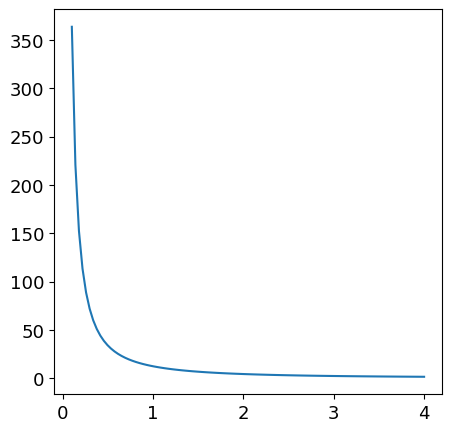

In [66]:
# see the behavior of sqrt(T(r))/r
r = np.linspace(0.1, 4, 100)
M_dot = 1e-9
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(r, np.sqrt(Temp(r, Z, M_dot))/r)
print('this shows the innermost parts collapse first since Q > 1 is stable')

In [67]:
rey_list = [1e14, 1e11, 1e8, 1e6, 1e5, 1e4, 1e3]
print(M1, M2i)

for M_dot in [1e-9, 1e-8, 1e-7]:
    for i, Rey in enumerate(rey_list):
        print('M_dot {:} Reynolds {:8.2e} Q {:10.5g}'.\
              format(M_dot, Rey, Q(M1, M2i, Temp(r_tr_Gl86_all[1][i]*a1i, Z, M_dot), 
                                   r_tr_Gl86_all[1][i]*a1i, M_dot, Rey)))

0.87 1.39
M_dot 1e-09 Reynolds 1.00e+14 Q 7.9231e-06
M_dot 1e-09 Reynolds 1.00e+11 Q  0.0064205
M_dot 1e-09 Reynolds 1.00e+08 Q     4.5944
M_dot 1e-09 Reynolds 1.00e+06 Q     336.97
M_dot 1e-09 Reynolds 1.00e+05 Q       3064
M_dot 1e-09 Reynolds 1.00e+04 Q      24561
M_dot 1e-09 Reynolds 1.00e+03 Q 1.8611e+05
M_dot 1e-08 Reynolds 1.00e+14 Q 1.0001e-06
M_dot 1e-08 Reynolds 1.00e+11 Q 0.00081892
M_dot 1e-08 Reynolds 1.00e+08 Q    0.59565
M_dot 1e-08 Reynolds 1.00e+06 Q     43.686
M_dot 1e-08 Reynolds 1.00e+05 Q     395.18
M_dot 1e-08 Reynolds 1.00e+04 Q     3105.1
M_dot 1e-08 Reynolds 1.00e+03 Q      22762
M_dot 1e-07 Reynolds 1.00e+14 Q 1.6105e-07
M_dot 1e-07 Reynolds 1.00e+11 Q 0.00013102
M_dot 1e-07 Reynolds 1.00e+08 Q   0.094762
M_dot 1e-07 Reynolds 1.00e+06 Q     7.0458
M_dot 1e-07 Reynolds 1.00e+05 Q     64.372
M_dot 1e-07 Reynolds 1.00e+04 Q     522.18
M_dot 1e-07 Reynolds 1.00e+03 Q     4022.1


__Truncation radius (in AU) vs Reynolds number at an eccentricity e_Gl86__

44.23 s


/Users/yunlin/anaconda3/envs/orbitpy3/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


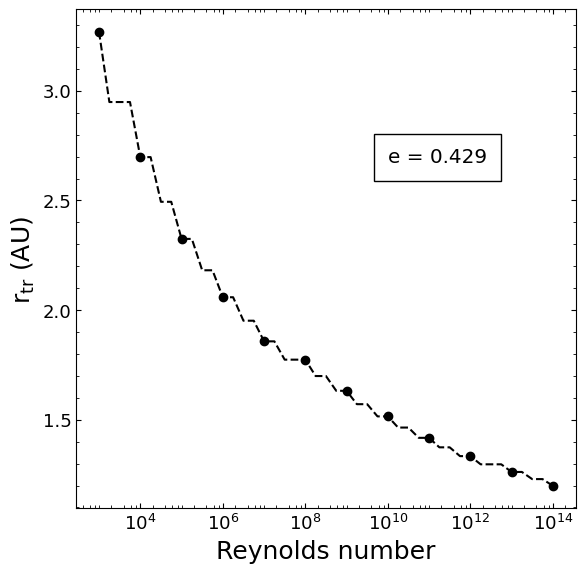

In [68]:
plt.rcParams.update(plt.rcParamsDefault)
font = {
    'font.size': 12,
    'axes.labelsize': 18, 
    'xtick.labelsize': 13, 
    'ytick.labelsize': 13, 
    'legend.fontsize': 11, 
    'savefig.dpi': 500
#     'axes.labelpad': 10
}
plt.rcParams.update(**font)

# def rtr_vs_Rey(r_tr_type, disk_type, reys, m, ls, e, a, use_eq78, title='',
#                fname='rtr_vs_R', only_plot=True, only_rtr=False, both_plot_rtr=False)
reys = np.logspace(14, 3, 45)
ls = np.arange(3, 29, 1)

kwargs = {
    'title': '', 
    'fname': 'rtr_vs_R', 
    'only_plot': True
}

rtr_vs_Rey('ILR', 'primary', reys, 4, 2, ls, e_Gl86, a1i, **kwargs)

__Represent the result as a 2D colormap__

need to change the $a$ below to $ai$

In [69]:
print('check values', M1, M2, a1i, e_Gl86)

check values 0.87 0.5424875614378722 14.832757971088395 0.42861485672471167


In [70]:
# remind myself of each argument in M_disk function
# def M_disk(rmin, rmax, Z, M_dot, alpha=None, Reynolds=None):

start = time.time()

M_dot = np.logspace(-9, -7, 21)
rey_list = np.logspace(5, 8, 17)
r_tr = fig5(a1i, 2, 'ILR', 'primary', rey_list, l_list_full, e_range=(0, 0.8), stop_at_rtr=True)[1]
REY_LIST, M_DOT = np.meshgrid(rey_list, M_dot)
R_TR, M_DOT = np.meshgrid(r_tr, M_dot)

end = time.time()
print('{:.2f} s'.format(end - start))

682.01 s


In [71]:
M_disk_vec = np.vectorize(M_disk)
Q_vec = np.vectorize(Q)
Temp_vec = np.vectorize(Temp)

# multiply by 0.01 because we want the dust mass
# remember to multiply an a to the R_TR
MASS = M_disk_vec(0.13, R_TR*a1i, Z, M_DOT, Reynolds=REY_LIST)[0]
QQ = Q_vec(M1, M2i, Temp_vec(R_TR*a1i, Z, M_DOT), R_TR*a1i, M_DOT, REY_LIST)

In [72]:
# interpolate the above results using a 10X dense grid
f_mass = interp2d(rey_list, M_dot, MASS)
f_Q = interp2d(rey_list, M_dot, QQ)
rey_list_new = np.logspace(5, 8, 450)
M_dot_new = np.logspace(-9, -7, 210)
REY_LIST_new, M_DOT_new = np.meshgrid(rey_list_new, M_dot_new)

MASS_new = f_mass(rey_list_new, M_dot_new)
Q_new = f_Q(rey_list_new, M_dot_new)

/Users/yunlin/anaconda3/envs/orbitpy3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


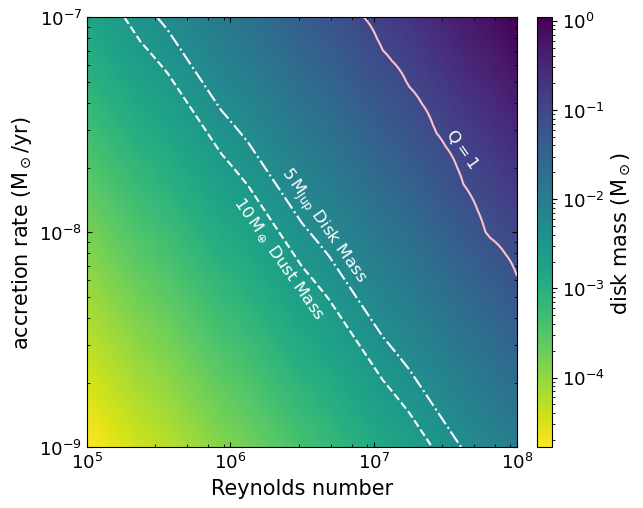

In [73]:
plt.rcParams.update(plt.rcParamsDefault)
font = {
    'font.size': 12,   # this affects the axis label, text, and title
    'axes.labelsize': 15, 
    'axes.titlesize': 16,     
    'xtick.labelsize': 13, 
    'ytick.labelsize': 13,
    'legend.fontsize': 11, 
    'savefig.dpi': 500
}
plt.rcParams.update(**font)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

pm = ax.pcolormesh(REY_LIST_new, M_DOT_new, MASS_new, norm=colors.LogNorm(vmin=MASS_new.min(), vmax=MASS_new.max()),
               cmap='viridis_r', shading='flat')

cax = make_square_axes_with_colorbar(ax, size=0.15, pad=0.2)
cbar = fig.colorbar(pm, cax=cax)

# draw a contour curve to indicate the Toomre parameter Q = 1
Q_contour = ax.contour(REY_LIST_new, M_DOT_new, Q_new, levels=np.array([1]), colors='pink')

# draw a contour line to indicate 10 Earth mass. 1 earth mass = 3e-6 solar mass.
earth10 = ax.contour(REY_LIST_new, M_DOT_new, MASS_new, levels=np.array([3e-3]), colors='white',
                    linestyles='dashed')
jup5 = ax.contour(REY_LIST_new, M_DOT_new, MASS_new, levels=np.array([0.00477294]), colors='white',
                 linestyles='dashdot')

# Q_contour.collections[0].set_label(r'$\mathrm{Q = 1}$')
# earth10.collections[0].set_label(r'$10 \, \mathrm{M_\oplus}$ dust mass')
# jup5.collections[0].set_label(r'$5 \, \mathrm{M_{Jup}}$ disk mass')

ax.text(3e7, 2e-8, r'$\mathrm{Q = 1}$', rotation=-55, color='white')
ax.text(1e6, 4e-9, r'$10\,\mathrm{M_\oplus}$ Dust Mass', rotation=-55, color='white')
ax.text(2e6, 6e-9, r'$5\,\mathrm{M_{Jup}}$ Disk Mass', rotation=-55, color='white')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Reynolds number')
ax.set_ylabel(r'accretion rate $\mathrm{(M_\odot/yr)}$')
ax.tick_params(direction='in', which='both', left=True, right=True, bottom=True, top=True)
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(0.1, 1, 0.2), 
                                      numticks=100))
ax.xaxis.set_minor_formatter(NullFormatter())
cbar.ax.set_ylabel(r'disk mass $\mathrm{(M_\odot)}$')
# ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), facecolor='yellowgreen', ncol=3)

fig.savefig('plots/planet_formation/disk_mass_colormap', bbox_inches='tight')

## Error propagation

Do error propagation for $a$, and $r_{\rm tr}$.